In [1]:
# Data Processing & Feature Engineering
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

# Model Selection & Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Tree-based Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Deep Learning (RNN, LSTM) - TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout

# Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [2]:
def evaluate_model(X_test, y_test, model_name, model=None, y_pred= None):
    if y_pred is not None:
        y_pred = y_pred
    else:
        y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{model_name} Performance Metrics:")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"Mean Absolute Percentage Error: {mape:.4%}")
    print(f"R² Score: {r2:.4f}")
    
    return y_pred, mae, rmse, mape, r2

def plot_residuals(y_pred, y_test, model_name):
    resids = y_test - y_pred

    fig, ax = plt.subplots(1,2, figsize= (20, 6))

    sns.histplot(resids, kde= True, color= 'skyblue', ax= ax[0])
    ax[0].set_title(f"{model_name}: Residuals Distribution", fontsize= 14, fontweight= 'bold')
    ax[0].set_xlabel("Residual Value", fontweight= 'bold')
    ax[0].set_ylabel("Frequency", fontweight= 'bold')

    sns.scatterplot(x= y_test, y= y_pred, alpha= 0.4, ax= ax[1])
    ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw= 2)
    ax[1].set_title(f"{model_name}: Actual vs. Predicted Flight Prices", fontsize= 14, fontweight= 'bold')
    ax[1].set_xlabel('Actual Flight Price', fontweight= 'bold')
    ax[1].set_ylabel('Predicted Flight Price', fontweight= 'bold')
    

    plt.tight_layout()
    plt.show()

def plot_feature_importance(feature_importances, features, model_name):
    data= pd.DataFrame({'features': features, 'feature_importance': feature_importances})
    data = data.sort_values(by=['feature_importance'], ascending=False)

    plt.figure(figsize=(10,8))
    sns.barplot(x= data['feature_importance'], y= data['features'])
    plt.title(f"{model_name} Feature Importance", fontsize= 14, fontweight= 'bold')
    plt.xlabel('Feature Importance', fontweight= 'bold')
    plt.ylabel('Feature', fontweight= 'bold')

def create_sequences_by_group(df, sequence_length):
    X_seq_list = []
    y_seq_list = []

    groups = df.groupby(['flightDate', 'startingAirport', 'destinationAirport'])

    for group_keys, group_df in groups:
        # Sort the group by daysToDeparture
        group_df = group_df.sort_values("daysToDeparture")

        # Only build a sequence if the group is large enough.
        if len(group_df) <= sequence_length:
            continue

        # Drop columns that are used for grouping (keep flight date for reference)
        X_group = group_df.drop(columns=['totalFare', 'flightDate', 'startingAirport', 'destinationAirport'])

        # Dropping Bugged columns for now:
        X_group = X_group.drop(columns=['airlineCode', 'cabinClass'])

        y_group = group_df['totalFare']

        # Ensure the feature data is numeric (convert booleans to float, etc.)
        X_group = X_group.astype('float32')

        X_values = X_group.to_numpy()
        y_values = y_group.to_numpy().reshape(-1, 1)

        for i in range(len(X_values) - sequence_length):
            X_seq_list.append(X_values[i:i+sequence_length])
            y_seq_list.append(y_values[i + sequence_length])

    return np.array(X_seq_list), np.array(y_seq_list)

def plot_metrics(df, metrics, labels):
    fig, ax = plt.subplots(2, 2, figsize= (10, 12))
    ax = ax.flatten()
    
    x = df['Model']
    
    for i, (metric, label) in enumerate(zip(metrics, labels)):
        y = df[metric]

        if metric == "R²":
            colors = ["green" if val == y.max() else "blue" for val in y]
        else:
            colors = ["green" if val == y.min() else "blue" for val in y]

        ax[i].bar(x, y, color=colors)
        ax[i].set_xlabel("Model", fontsize=10)
        ax[i].set_ylabel(label, fontsize=10)
        ax[i].set_xticklabels(x, rotation=90)
        ax[i].set_title(f"{label} by Model", fontsize=12, fontweight="bold")

        if metric == 'MAE':
            ax[i].yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f'${y:,.0f}'))
    
    plt.tight_layout()
    plt.show()


In [3]:
df = pd.read_csv('/Users/casey/Documents/GitHub/AirFareCast/sample_data_lagged.csv')
df.head()

,searchDate,flightDate,startingAirport,destinationAirport,travelDuration,isRefundable,isNonStop,totalFare,seatsRemaining,airlineCode,...,isHoliday,nearHoliday,price_t_minus_1,price_t_minus_2,price_t_minus_3,price_t_minus_4,price_t_minus_5,price_t_minus_6,price_t_minus_7,price_t_plus_1
0,2022-07-06,2022-08-29,1,4,421,False,False,327.60,9,83,...,False,False,318.60,218.2,327.60,327.60,327.60,318.60,327.60,208.2
1,2022-06-21,2022-07-11,4,5,788,False,False,218.58,0,110,...,False,False,218.58,468.6,357.19,278.60,178.58,177.61,468.60,228.6
2,2022-08-27,2022-09-21,2,11,579,False,False,235.69,9,83,...,False,False,605.11,406.1,605.11,605.11,400.10,605.11,605.11,400.1
3,2022-09-28,2022-10-25,2,1,284,False,False,119.10,7,34,...,False,False,340.10,340.1,287.10,119.10,119.10,340.10,340.10,119.1
4,2022-06-12,2022-07-06,1,4,406,False,False,331.60,7,34,...,False,True,244.60,331.6,331.60,331.60,302.20,244.60,331.60,331.6


In [4]:
#Drop flightDate and searchDate
df = df.drop(columns=['flightDate', 'searchDate'])
df.head()

,startingAirport,destinationAirport,travelDuration,isRefundable,isNonStop,totalFare,seatsRemaining,airlineCode,cabinClass,travelDistance,...,isHoliday,nearHoliday,price_t_minus_1,price_t_minus_2,price_t_minus_3,price_t_minus_4,price_t_minus_5,price_t_minus_6,price_t_minus_7,price_t_plus_1
0,1,4,421,False,False,327.60,9,83,15,1565.000000,...,False,False,318.60,218.2,327.60,327.60,327.60,318.60,327.60,208.2
1,4,5,788,False,False,218.58,0,110,15,1609.903346,...,False,False,218.58,468.6,357.19,278.60,178.58,177.61,468.60,228.6
2,2,11,579,False,False,235.69,9,83,0,1649.000000,...,False,False,605.11,406.1,605.11,605.11,400.10,605.11,605.11,400.1
3,2,1,284,False,False,119.10,7,34,0,730.000000,...,False,False,340.10,340.1,287.10,119.10,119.10,340.10,340.10,119.1
4,1,4,406,False,False,331.60,7,34,15,1578.000000,...,False,True,244.60,331.6,331.60,331.60,302.20,244.60,331.60,331.6


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759691 entries, 0 to 759690
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   startingAirport     759691 non-null  int64  
 1   destinationAirport  759691 non-null  int64  
 2   travelDuration      759691 non-null  int64  
 3   isRefundable        759691 non-null  bool   
 4   isNonStop           759691 non-null  bool   
 5   totalFare           759691 non-null  float64
 6   seatsRemaining      759691 non-null  int64  
 7   airlineCode         759691 non-null  int64  
 8   cabinClass          759691 non-null  int64  
 9   travelDistance      759691 non-null  float64
 10  departureTimeHour   759691 non-null  int64  
 11  daysToDeparture     759691 non-null  int64  
 12  departureDayOfWeek  759691 non-null  int64  
 13  isWeekend           759691 non-null  bool   
 14  isHoliday           759691 non-null  bool   
 15  nearHoliday         759691 non-nul

In [7]:
# Our X variables in these models will be all columns that are not price
X = df.drop(columns= ['price_t_plus_1'], axis= 1)

# Our y variable is of course price which is called 'totalFare'
y = df['price_t_plus_1']

# Split the data into train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [8]:
# Smaller sample for hyperparameter tuning to save time
sample_indices = np.random.choice(len(X_train), min(100000, len(X_train)), replace=False)
X_train_sample = X_train.iloc[sample_indices]
y_train_sample = y_train.iloc[sample_indices]
print(f"Using {len(X_train_sample)} samples for hyperparameter tuning")

Using 100000 samples for hyperparameter tuning


In [9]:
print("--- XGBoost Hyperparameter Tuning ---")
xgb_param_grid = {
    'n_estimators': [100, 200], 
    'max_depth': [6, 12, 18],  
    'learning_rate': [0.05, 0.1],  
    'colsample_bytree': [0.8, 1.0],  
    'min_child_weight': [1, 3],  
    'gamma': [0, 0.1]  
}

xgb_grid = GridSearchCV(
    XGBRegressor(random_state= 42, n_jobs= -1, enable_categorical= True),
    param_grid= xgb_param_grid,
    cv= 3,
    scoring= 'neg_mean_absolute_error',
    n_jobs= -1,
    verbose= 1
)

print("Training XGBoost models...")
xgb_grid.fit(X_train_sample, y_train_sample)

print("Best XGBoost parameters:")
print(xgb_grid.best_params_)
print(f"Best CV score: {-xgb_grid.best_score_:.4f} RMSE")

--- XGBoost Hyperparameter Tuning ---
Training XGBoost models...
Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best XGBoost parameters:
{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 12, 'min_child_weight': 1, 'n_estimators': 200}
Best CV score: 60.5939 RMSE


In [10]:
# Running the model with the best parameters on the whole dataset
xgb = XGBRegressor(**xgb_grid.best_params_, random_state= 42, enable_categorical= True)
xgb.fit(X_train, y_train)  
xgb_y_pred, xgb_mae, xgb_rmse, xgb_mape, xgb_r2 = evaluate_model(X_test, y_test, "XG Boost", model= xgb)

# Saving the model results 
xgb_metrics = {
    "Model": "XG Boost",
    "MAE": xgb_mae,
    "RMSE": xgb_rmse,
    "MAPE": xgb_mape,
    "R²": xgb_r2
}

XG Boost Performance Metrics:
Mean Absolute Error: 56.7071
Root Mean Squared Error: 104.3020
Mean Absolute Percentage Error: 19.6601%
R² Score: 0.7128


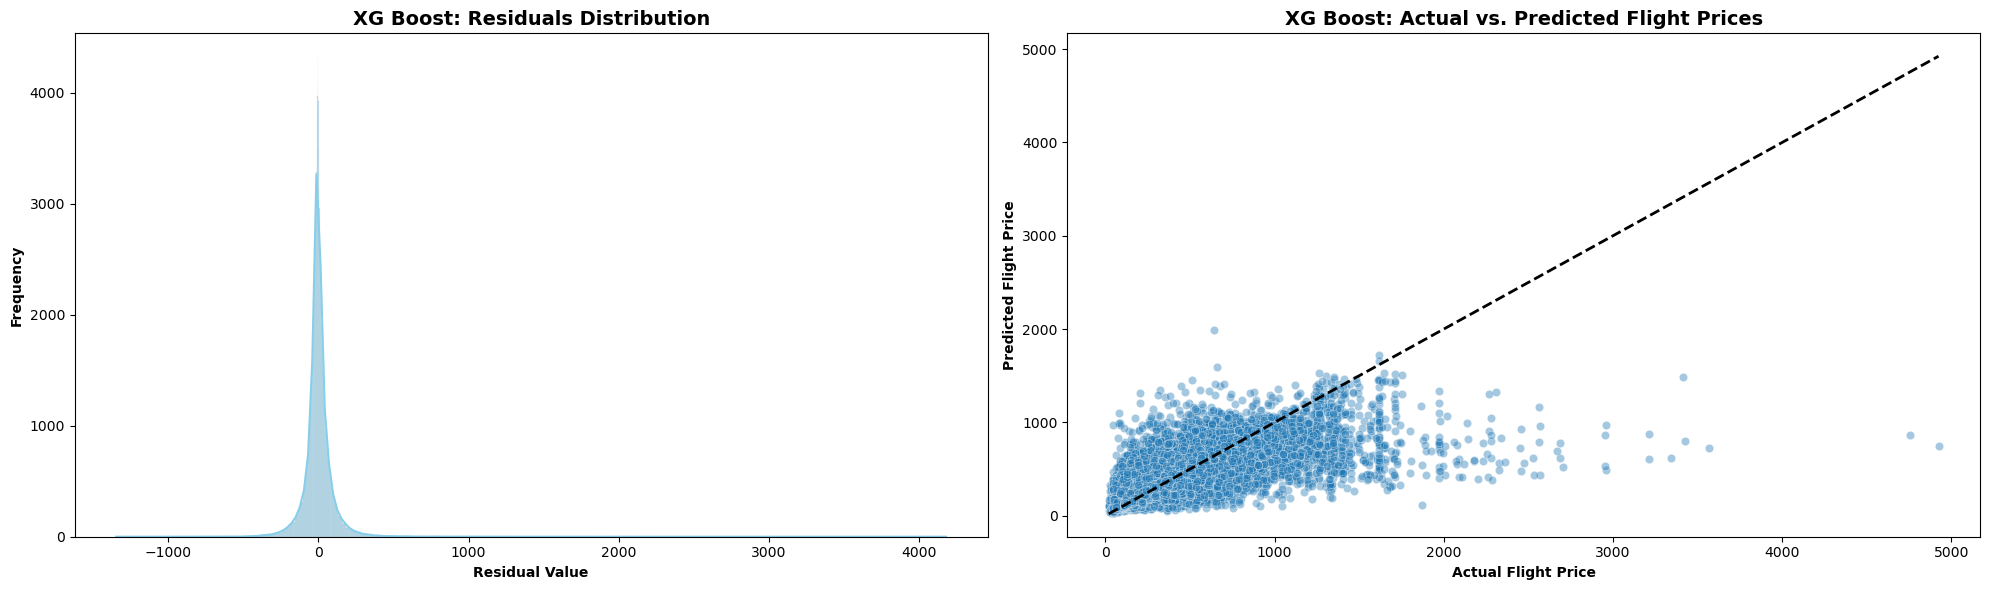

In [11]:
plot_residuals(xgb_y_pred, y_test, "XG Boost")

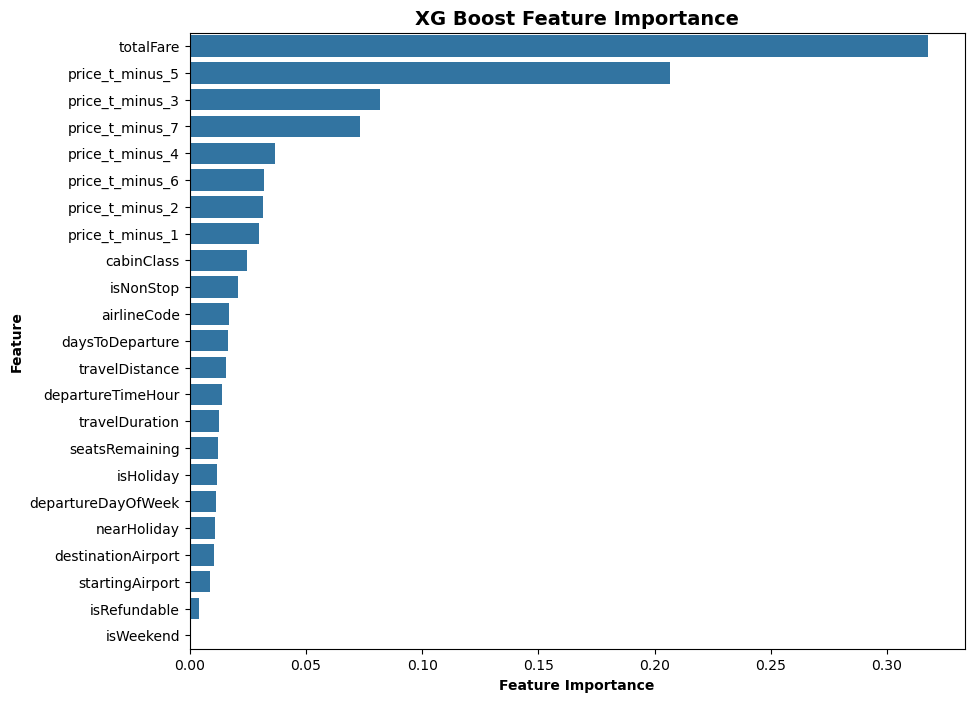

In [12]:
plot_feature_importance(xgb.feature_importances_, X_train.columns, "XG Boost")